In [45]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
import matplotlib.dates as mdates
import math
from scipy import interpolate, stats, special
from scipy import arange, array, exp
from astropy.coordinates import SkyCoord

RAD2DEG = 180./np.pi
DEG2RAD=np.pi/180

In [46]:
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


In [47]:
# angular separation between two events
def spcang (ra1, ra2, dec1, dec2):
    return np.arccos(np.cos(dec1*DEG2RAD)*np.cos(dec2*DEG2RAD)*np.cos((ra1-ra2)*DEG2RAD)+np.sin(dec1*DEG2RAD)*np.sin(dec2*DEG2RAD))*RAD2DEG
    
# calculating signalness for IceCube events    
def signaless(n):
    normed_hist = \
    [  0.00000000e+00,  5.99855625e-06,  2.56068410e-06,  2.00041249e-04,
       4.96561472e-01,  1.80710446e+00,  1.53757070e+00,  6.19210631e-01,
       2.69402835e-01,  1.04740183e-01,  7.86432556e-02,  4.19244509e-02,
       2.51411438e-02,  9.83825515e-03,  4.66870813e-03,  2.57092417e-03,
       1.48438797e-03,  6.00967147e-04,  2.68416599e-04,  6.06027188e-05]
    bins_log10_signalness = \
    [-4., -3.8, -3.6, -3.4, -3.2, -3.,  -2.8, -2.6, -2.4, -2.2, -2.,  -1.8, -1.6, -1.4, -1.2,
     -1., -0.8, -0.6, -0.4, -0.2,  0. ]
    
    bins = np.asarray(bins_log10_signalness)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    
    f2 = interp1d(bin_centers, normed_hist)
    xnew=np.linspace(-3.8,-0.1,40)
    
    cdf = np.cumsum(f2(xnew))
    cdf = cdf / cdf[-1]
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = xnew[value_bins]
    return random_from_cdf

# Likelihood function for each gamma-neutrino pair
def LLH(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    #Setting variables
    spc = spcang(ra1, ra2, dec1, dec2)
    
    ra1=ra1*DEG2RAD
    dec1=dec1*DEG2RAD
    ra2=ra2*DEG2RAD
    dec2=dec2*DEG2RAD
    
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    
    #Finding the best position using Colin's approach
    #first combine uncertainties
    sigma=1/(1/sigma1**2+1/sigma2**2)
    #now we calculate f, the distance from particle 1 to best fit position
    f=sigma/sigma2**2 #f should be between 0 and 1
    #define some intermediate parameters
    a=np.sin((1-f)*spc*DEG2RAD)/np.sin(spc*DEG2RAD)
    b=np.sin(f*spc*DEG2RAD)/np.sin(spc*DEG2RAD)
    x=a*np.cos(dec1)*np.cos(ra1)+b*np.cos(dec2)*np.cos(ra2)
    y=a*np.cos(dec1)*np.sin(ra1)+b*np.cos(dec2)*np.sin(ra2)
    z=a*np.sin(dec1)+b*np.sin(dec2)
    #now plug these parameters into the arctan2 function (quadrant sensitive arctangent) to find the best fit ra,dec
    ra0=np.arctan2(y,x)
    dec0=np.arctan2(z,np.sqrt(x**2+y**2))
    ra0%=2*np.pi #use modulo operator to make sure ra falls between 0 and 2pi
    ra_best=ra0*RAD2DEG
    dec_best=dec0*RAD2DEG
    if ra_best < 0 : ra_best = ra_best + 360
    else : ra_best = ra_best
    #print dec1*RAD2DEG, dec2*RAD2DEG, dec_best, ra1*RAD2DEG, ra2*RAD2DEG, ra_best, a, b
    
    #Calculating the likelihood
    #Spatial coincidence
    sigmac=sigma1**2+ sigma2**2 #Being conservative in the error  
    xerf=spc**2/(2*sigmac)#(np.sqrt(2)*np.sqrt(sigmac))
    term1 = -np.log(2*np.pi*sigmac)/2 - xerf
    #Db = (np.log(0.25*(sig1**2/sig2**2 + sig2**2/sig1**2 + 2)) + xerf)*0.25
    #BC = np.exp(-Db) #Bhattacharyya distance
    #H = 1 - BC #
    #term1 = np.log(BC)-np.log(H) #Bigger value, means gaussian are similar to each other. 
    #if xerf<5.:
    #pdst = special.erf(xerf) #Probability of distance being less than ∆theta
    #if pdst==1.: print xerf
    #pndst = 1 - pdst #probability distance begin more than ∆theta
    #term1 = np.log(pdst) - np.log(pndst)#-np.log(2*np.pi*sigc)/2
    #    else:
    #        pndst = special.erfc(xerf)
    #        term1 = -pndst - np.log(pndst)
    #        if term1==inf: print pndst,xerf,sig2,sig1,dst
    
    #IC and HAWC contributions
    #HAWC Signficance sig=2[ln(p(data|signal+bkg))-ln(p(data|bkg))]
    phwc = stats.norm.cdf(sig) #HAWC significances
    pIC = np.power(10,signaless(1))[0] #IC Signaless
    if pIC!=1: 
        term2 = sig**2/2 + np.log(pIC) - np.log(1-pIC)#sig**2  
    else:
        term2 = sig**2/2
        
    llh = term1 + term2
    
    return [dec_best, ra_best, np.sqrt(sigma), np.sqrt(sigmac), term1, term2, llh] 

    #if dst/(np.sqrt(2)*sigc)<6.:
        #llh = term1 + term2 #+ term3  ##LIKELIHOOD
    #else:
        #llh = term1 #should be -20

        
def spcang_trange_llh (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            #th1 = SkyCoord(h[1][1],h[1][0],unit='deg')
            #th2 = SkyCoord(ic[1][1],ic[1][0],unit='deg')
            #spc = th1.separation(th2).value
            
            if spc < minspc :
                #print i,j
                llh_list = LLH(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[2], llh_list[3], llh_list[4], llh_list[5],llh_list[6]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','SigQ','T1','T2','LLH'])
    return result


In [48]:
#dfh = pd.read_csv("/Users/Azadeh/Desktop/related_amon/IC-HAWC/files/monthly_maps/HAWC-Jan16.csv")
dfh = pd.read_csv("hawc_data_2.csv")
dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])

In [49]:
dfic = pd.read_csv("IC-singlet-Dec15old-Jan16new-shuffled.csv")
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')

In [51]:
dfic.head(500)[205:210]

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec
5543,70.0049,223.4110,1.01584,2016-01-01 19:47:36,201092
3931,34.7977,275.1130,1.79516,2016-01-01 20:01:02,217920
4350,64.8118,270.5510,3.07204,2016-01-01 20:10:37,347249
4824,80.8512,252.5080,3.06175,2016-01-01 20:14:46,800816
5001,44.1483,53.5088,1.37765,2016-01-01 20:16:41,167690


In [52]:
%%time
spca = 3.5
# df_result1 = spcang_trange_llh1(dfic, dfh, spca)
# df_result1.to_csv("IC_HAWC_bkg_1.csv",index=False,encoding='utf-8')
# df_result2 = spcang_trange_llh2(dfic, dfh, spca)
# df_result2.to_csv("IC_HAWC_bkg_2.csv",index=False,encoding='utf-8')
df_result = spcang_trange_llh(dfic, dfh, spca)
df_result.to_csv("IC_HAWC_bkg.csv",index=False,encoding='utf-8')

CPU times: user 50.2 s, sys: 207 ms, total: 50.4 s
Wall time: 50.5 s


In [53]:
df_result.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,HDec,HRA,HsigmaR,HTime_i,HTime_c,HTime_f,Hduration,Hsig,SpcAng,Best_fit_dec,Best_fit_ra,Best_pos_err,SigQ,T1,T2,LLH
0,34.7977,275.113,1.795160,2016-01-01 20:01:02,33.3312,271.890,0.75,2016-01-01 14:18:31,2016-01-01 17:54:04,2016-01-01 21:29:37,7.18509,3.20798,3.045947,33.337800,271.903867,0.118775,1.799102,-2.939413,-1.637069,-4.576483
1,34.7977,275.113,1.795160,2016-01-01 20:01:02,34.5452,272.110,0.75,2016-01-01 14:19:41,2016-01-01 17:54:56,2016-01-01 21:30:11,7.17481,3.60946,2.482528,34.547274,272.131486,0.152088,1.801637,-2.456978,-0.924432,-3.381411
2,16.6642,272.744,0.834174,2016-01-01 16:36:03,18.3277,271.934,0.75,2016-01-01 14:23:02,2016-01-01 17:54:22,2016-01-01 21:25:42,7.04470,2.96565,1.834115,18.297378,271.948915,0.112678,0.841890,-3.119912,-2.166370,-5.286282
3,34.7977,275.113,1.795160,2016-01-01 20:01:02,35.8232,276.065,0.75,2016-01-01 14:35:54,2016-01-01 18:10:42,2016-01-01 21:45:30,7.15974,2.89521,1.286515,35.817000,276.059150,0.139834,1.800631,-1.762317,-0.618478,-2.380795
4,26.6468,273.461,2.543030,2016-01-01 21:09:15,24.5012,276.328,0.75,2016-01-01 14:37:07,2016-01-01 18:11:51,2016-01-01 21:46:35,7.15769,3.39708,3.360062,24.508499,276.318538,0.147394,2.547312,-2.723939,-1.012561,-3.736500


In [54]:
len(df_result)

1367

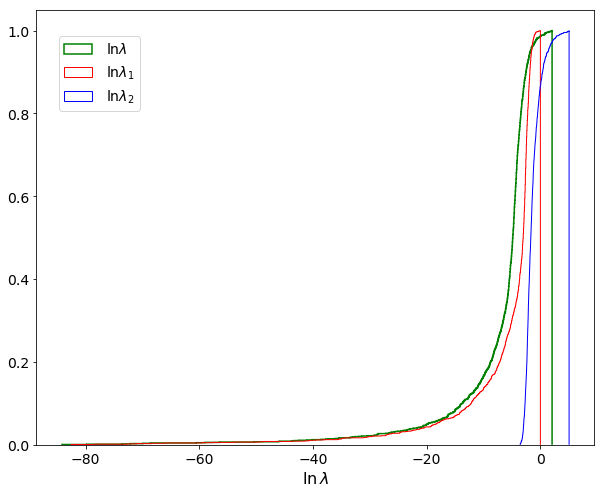

In [56]:
#rcParams['figure.figsize'] = (10, 8)
rcParams['font.size']=14
cllh=plt.hist(df_result.LLH,cumulative=True,normed=1,
         histtype='step',
         color='g',
         lw=1.5,
         bins=2000,
         label=r'$\ln \lambda$')
cllh1=plt.hist(df_result.T1,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=2000,
         label=r'$\ln \lambda_1$')
cllh2=plt.hist(df_result.T2,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=2000,
         label=r'$\ln \lambda_2$')
# cllh=plt.hist(df_result.T3,cumulative=True,normed=1,
#          histtype='step',
#          color='k',
#          lw=1.,
#          bins=2000,
#          label='T3')
#xlim(-20,70)
#perc2 = np.percentile(df_result.LLH,99.99)
#plt.vlines(perc2,0,0.9999,color='green',linestyles='--',lw=1.5)
l=legend(bbox_to_anchor=(0.04,0.94),loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'$\ln \, \lambda$',fontsize=16)
#savefig('/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/CLLH.pdf')

In [203]:
delta = (max(df_result.LLH)+10)/100.
binst1 = (max(df_result.T1)+10)/delta
binst2 = (max(df_result.T2)-min(df_result.T2))/delta
#binst3 = max(df_result.T3)-min(df_result.T3)/delta
#min(df_result.ICsigmaR)
binst1

78.910874593554084

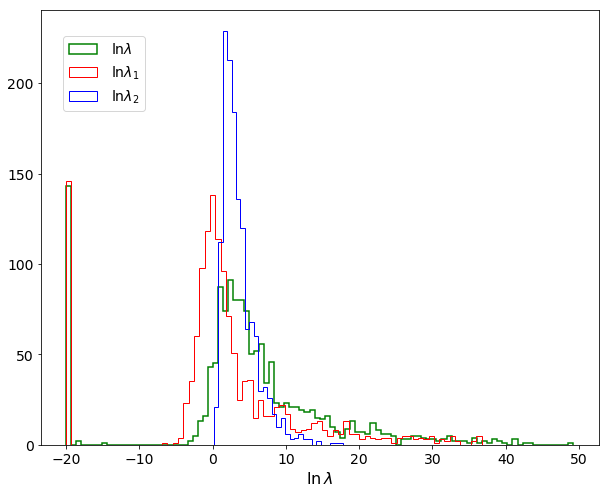

In [204]:
rcParams['figure.figsize'] = (10, 8)
# llh=plt.hist(df_result1.LLH,cumulative=False,normed=1,
#          histtype='step',
#          color='b',
#          lw=1.,
#          bins=200,
#          label='bkg')
# llh=plt.hist(df_result2.LLH,cumulative=False,normed=1,
#          histtype='step',
#          color='r',
#          lw=1.,
#          bins=200,
#          label='bkg')
llh=plt.hist(df_result.LLH,cumulative=False,normed=0,
         histtype='step',
         color='g',
         lw=1.5,
         bins=100,
         label=r'$\ln \lambda$',range=[-20,max(df_result.LLH)])
t1=plt.hist(df_result.T1,cumulative=False,normed=0,
         histtype='step',
         color='r',
         lw=1.,
         bins=int(binst1),
         label=r'$\ln \lambda_1$',range=[-20,max(df_result.T1)])
t2=plt.hist(df_result.T2,cumulative=False,normed=0,
         histtype='step',
         color='b',
         lw=1.,
         bins=int(binst2),
         label=r'$\ln \lambda_2$',range=[min(df_result.T2),max(df_result.T2)])
# t3=plt.hist(df_result.T3,cumulative=False,normed=0,
#          histtype='step',
#          color='k',
#          lw=1.,
#          bins=int(binst3),
#          label='T3')
l=legend(bbox_to_anchor=(0.04,0.94),loc=2,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})

xlabel("logLH")
#xlim(-10,70)
xlabel(r'$\ln \, \lambda$',fontsize=16)
savefig('/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/PLLH.pdf')

In [129]:
# from matplotlib.colors import LogNorm
# hist2d(df_result.T1,df_result.T1/df_result.LLH,bins=100,norm=LogNorm(),cmap='viridis_r',
#       range=[[-10,70], [-1,1]]
#       )

# colorbar()
# xlabel(r"T1",fontsize=16)
# ylabel(r'T1/$\ln \lambda$',fontsize=16)
# #ylim(-1,1)
# #hlines(0,-5,1,linestyles='--',lw=1)
# #zscale('log')np.log(1-phwc)
# savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsLLH.pdf")

In [211]:
# from matplotlib.colors import LogNorm
# rcParams['figure.figsize'] = (10, 8)
# hist2d(df_result.T2,df_result.T2/df_result.LLH,bins=50,cmap='viridis_r',norm=LogNorm(),
#        range=[[-10,70], [-1,1]]
#       )

# xlabel(r"T2",fontsize=16)
# ylabel(r'T2/$\ln \lambda$',fontsize=16)
# #xlim(-10,0)
# #ylim(0,1)
# colorbar()
# #zscale('log')np.log(1-phwc)
# savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T2vsLLH.pdf")
max(df_result.LLH)

49.227325524402247

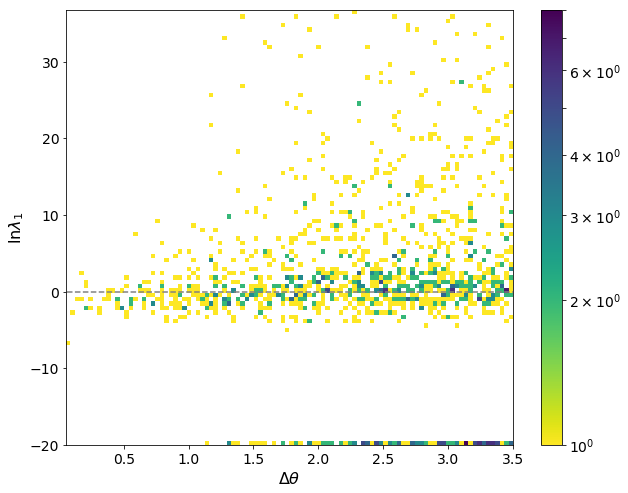

In [180]:
from matplotlib.colors import LogNorm
hist2d(df_result.SpcAng,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$\Delta \theta$",fontsize=16)
ylabel(r'$\ln \lambda_1$',fontsize=16)
hlines(0,0,3.5,linestyles='--',colors='gray')
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsTheta.pdf")

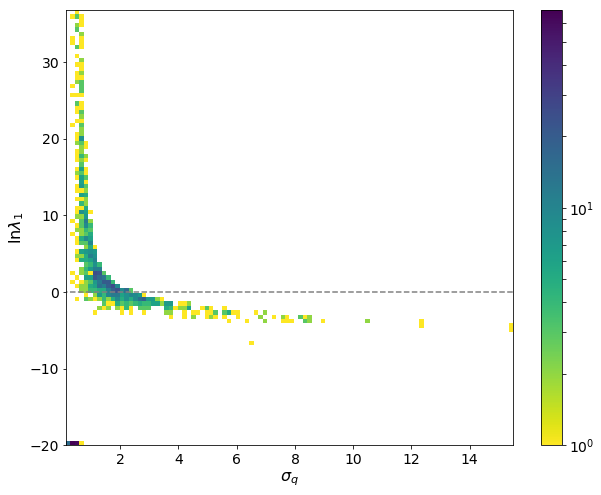

In [181]:
rcParams['figure.figsize'] = (10, 8)
from matplotlib.colors import LogNorm
hist2d(df_result.Best_pos_err,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$\sigma_q$",fontsize=16)
ylabel(r'$\ln \lambda_1$',fontsize=16)
hlines(0,0,16,linestyles='--',colors='gray')
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vssigma.pdf")

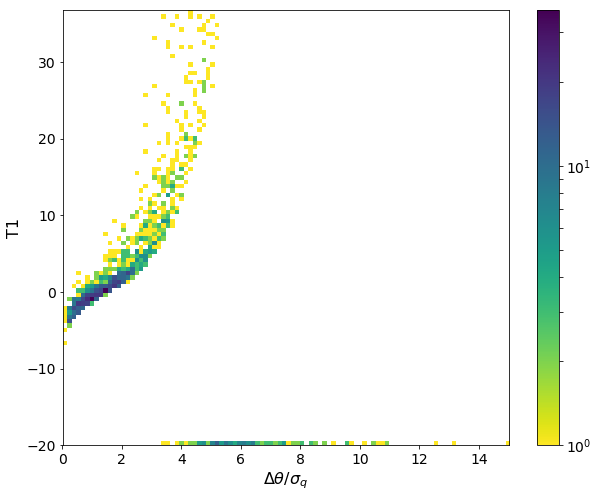

In [182]:
from matplotlib.colors import LogNorm
hist2d(df_result.SpcAng/df_result.Best_pos_err,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$\Delta \theta / \sigma_q$",fontsize=16)
ylabel(r'T1',fontsize=16)
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/T1vsZ.pdf")

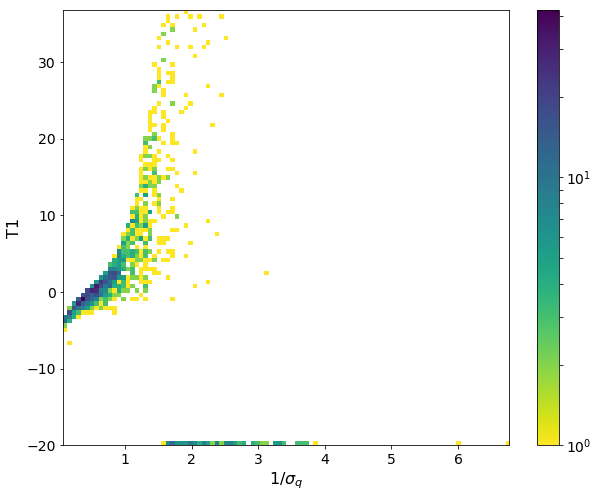

In [183]:
rcParams['figure.figsize'] = (10, 8)
from matplotlib.colors import LogNorm
hist2d(1/df_result.Best_pos_err,df_result.T1,bins=100,cmap='viridis_r',norm=LogNorm())
colorbar()
xlabel(r"$1/\sigma_q$",fontsize=16)
ylabel(r'T1',fontsize=16)
#ylim(-1,0)

(0, 0.55)

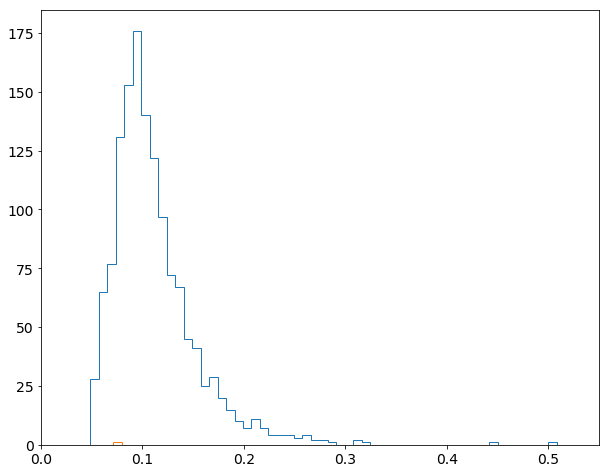

In [218]:
rcParams['figure.figsize'] = (10, 8)
#hist(df_result.Best_pos_err[df_result.LLH>-20],bins=50,histtype='step',)
hist(df_result.Best_pos_err,bins=55,histtype='step')
hist(df_result.Best_pos_err[df_result.LLH>48],bins=110,histtype='step')
#hist(df_result.SigQ,bins=50,histtype='step')
#hist(df_result.ICDec,bins=50,histtype='step')
xlim(0,0.55)

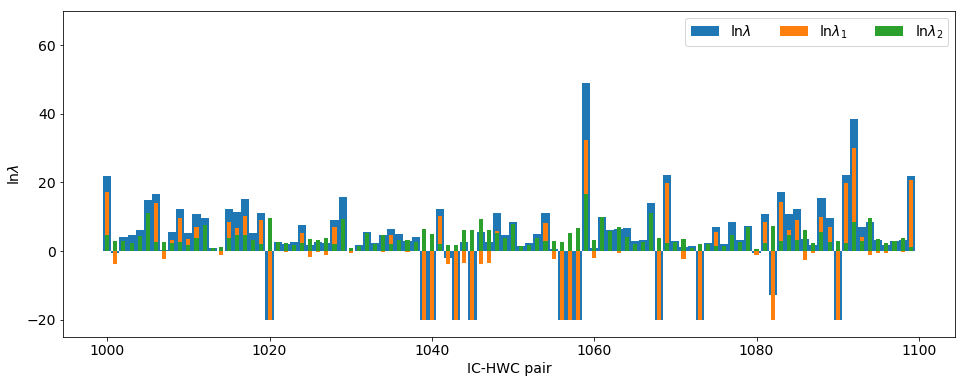

In [185]:
rcParams['figure.figsize']=16,6
x=np.arange(0,len(df_result))
mini=1000
maxi=1100
bar(x[mini:maxi],df_result.LLH[mini:maxi],label=r'$\ln \lambda$',width=1)
bar(x[mini:maxi],df_result.T1[mini:maxi],label=r'$\ln \lambda_1$',width = 0.5)
bar(x[mini:maxi],df_result.T2[mini:maxi],label=r'$\ln \lambda_2$',width = 0.5)
legend(ncol=3)
xlabel("IC-HWC pair")
ylabel(r"$\ln \lambda$")
ylim(-25,70)
savefig("/Users/hugo/AMON/Technical_Notes/IC-HAWC_Analysis/indllh.pdf")

In [417]:
def smallLikelihood(dst,sigc):
    llh =  - dst**2/(2*sigc)
    return llh

X,Y = meshgrid(df_result.SpcAng,df_result.Best_pos_err**2)
Z = smallLikelihood(X,Y).T



In [177]:
max(df_result.Best_pos_err)

15.477248331498567

In [186]:
Nside = 32
degree = np.pi/180.
sky99 = np.zeros(hp.nside2npix(Nside))
sky95 = np.zeros(hp.nside2npix(Nside))
perc99 = np.percentile(df_result.LLH,99)
perc95 = np.percentile(df_result.LLH,95)
for i,r in df_result.iterrows():
    dec =  r['Best_fit_dec']
    th = 90.-dec
    ra = r['Best_fit_ra']
    j=hp.ang2pix(Nside,th*degree,ra*degree)
    if r['LLH'] > perc99:
        sky99[j] = r["LLH"]
    if r['LLH'] > perc95:
        sky95[j] = r["LLH"]

0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 10 deg 0.00'.
The interval between meridians is 10 deg 0.00'.


48.96561881005988

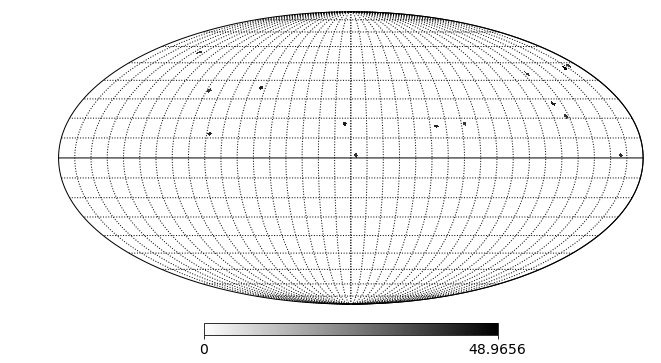

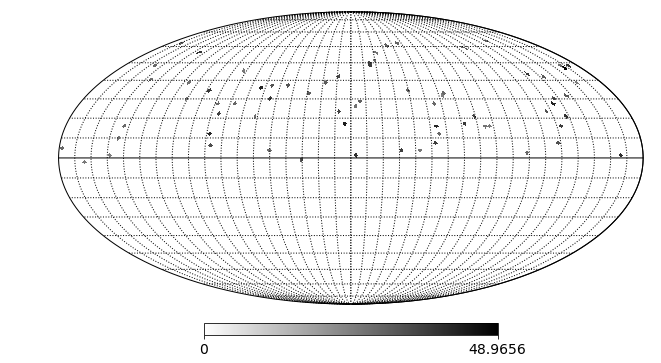

In [187]:
hp.mollview(sky99,rot=180,title='',cmap='gray_r')
hp.graticule(dpar=10)
hp.mollview(sky95,rot=180,title='',cmap='gray_r')
hp.graticule(dpar=10)
np.max(df_result.LLH)

In [135]:
dfic = pd.read_csv("IC_scrambled/0.csv".format(i))
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')
dfic.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec
5147,37.6468,234.510,0.748392,2016-01-01 00:00:40,687458
7014,16.2288,251.664,1.456150,2016-01-01 00:07:29,848553
1218,37.7610,252.420,0.927968,2016-01-01 00:09:24,249790
8163,10.7883,100.428,8.220370,2016-01-01 00:11:59,139309
5878,87.2418,163.700,0.399145,2016-01-01 00:15:36,873420


In [136]:
spca = 3.5
df_result=[]
for i in range(1):
    dfic = pd.read_csv("IC_scrambled/{}.csv".format(i))
    dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
    dfic = dfic.sort_values(by='ICtime')
    df_result.append(spcang_trange_llh(dfic, dfh, spca))
    df_result[i].to_csv("bkg_coinc/IC_HAWC_bkg_{}.csv".format(i),
          index=False,encoding='utf-8')

In [137]:
#1367
len(df_result)
flat = pd.concat(df_result,ignore_index=True)

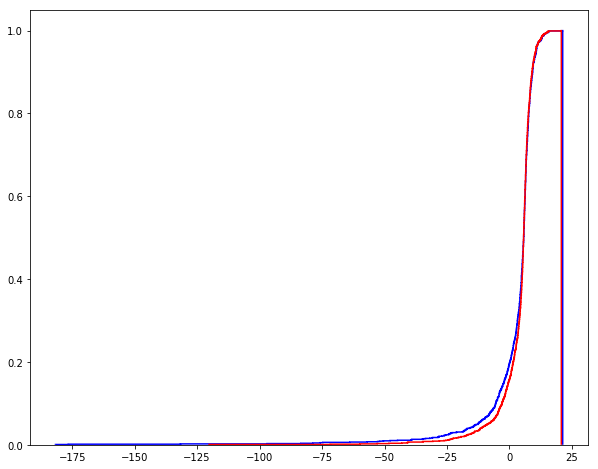

In [138]:
for i in xrange(len(df_result)):
    cllh=plt.hist(df_result[i].LLH1,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.5,
         bins=2000,
         label='bkg')
    cllh=plt.hist(df_result[i].LLH2,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.5,
         bins=2000,
         label='bkg')

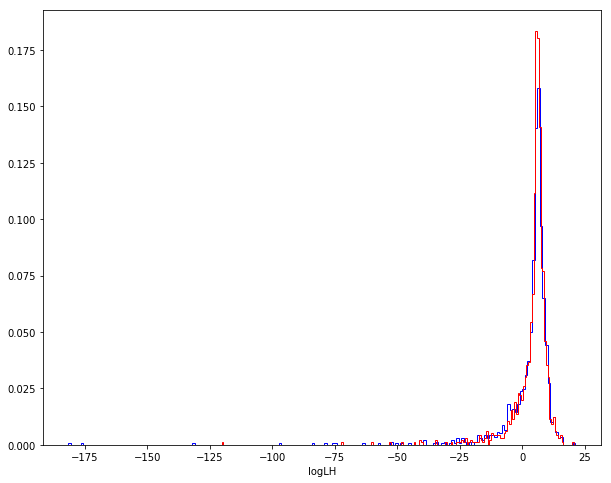

In [139]:
for i in xrange(len(df_result)):
    llh=plt.hist(df_result[i].LLH1,cumulative=False,normed=1,
         histtype='step',
         color='b',
         lw=1.,
         bins=200,
         label='bkg')
    llh=plt.hist(df_result[i].LLH2,cumulative=False,normed=1,
         histtype='step',
         color='r',
         lw=1.,
         bins=200,
         label='bkg')
xlabel("logLH")

(-10, 25)

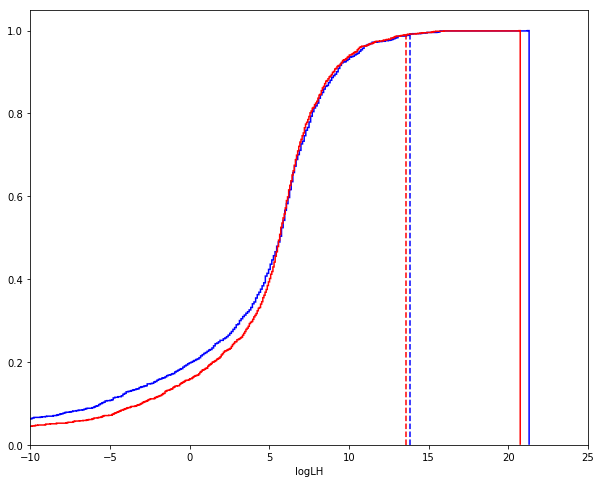

In [141]:
perc1 = np.percentile(flat.LLH1,99)
perc2 = np.percentile(flat.LLH2,99)

cllh=plt.hist(flat.LLH1,cumulative=True,normed=1,
         histtype='step',
         color='b',
         lw=1.5,
         bins=2000,
         label='bkg')
cllh=plt.hist(flat.LLH2,cumulative=True,normed=1,
         histtype='step',
         color='r',
         lw=1.5,
         bins=2000,
         label='bkg')
plt.vlines(perc1,0,0.99,color='blue',linestyles='--')
plt.vlines(perc2,0,0.99,color='red',linestyles='--')
xlabel('logLH')
xlim(-10,25)

In [19]:
import healpy as hp

In [150]:
Nside = 64
degree = np.pi/180.
sky = np.zeros(hp.nside2npix(Nside))
sky2 = np.zeros(hp.nside2npix(Nside))
perc1 = np.percentile(flat.LLH1,99)
perc2 = np.percentile(flat.LLH2,99)
for i,r in flat.iterrows():
    dec =  r['Best_fit_dec']
    th = 90.-dec
    ra = r['best_fit_ra']
    j=hp.ang2pix(Nside,th*degree,ra*degree)
    if r['LLH1'] > perc1:
        sky[j] = r["LLH1"]
        #print "Time1: ",r['HTime_c']
    if r['LLH1'] > perc2:  
        sky2[j] = r["LLH2"]
        print "Time2: ",r['HTime_c']

Time2:  2016-01-02 14:35:48
Time2:  2016-01-05 04:16:19
Time2:  2016-01-05 04:16:19
Time2:  2016-01-06 09:16:04
Time2:  2016-01-07 00:23:50
Time2:  2016-01-10 21:24:04
Time2:  2016-01-10 23:36:12
Time2:  2016-01-11 23:07:00
Time2:  2016-01-16 10:02:42
Time2:  2016-01-17 10:13:08
Time2:  2016-01-20 12:18:42
Time2:  2016-01-21 06:24:49
Time2:  2016-01-21 22:46:17
Time2:  2016-01-22 15:18:53
Time2:  2016-01-23 13:50:49
Time2:  2016-01-24 16:42:24
Time2:  2016-01-26 00:05:14
Time2:  2016-01-26 15:26:15


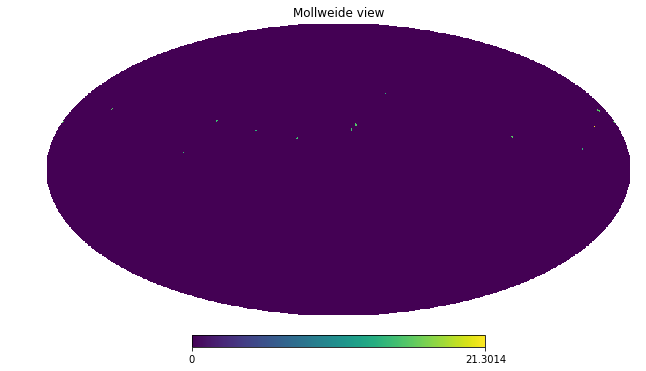

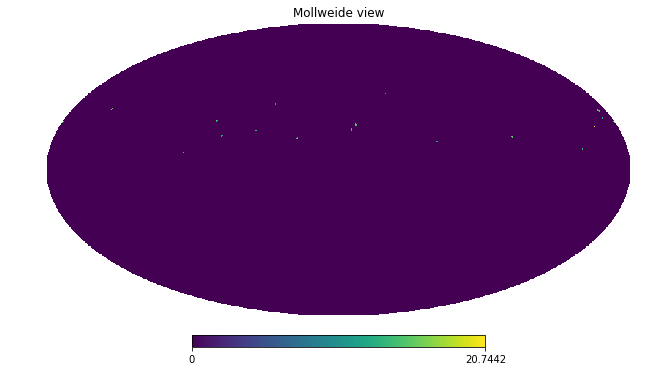

In [147]:
hp.mollview(sky,rot=180,min = 0)
hp.mollview(sky2,rot=180,min = 0)

Archive: everything down here is archived in case we need them later

In [ ]:
# The first likelihood method that we used but we realized it is not completely right since at larger angular separation, it malfunctions.
def LLH1(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#0.11#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    if abs(ra1-ra2)>300:
        if ra1>ra2:
            ra1=ra1-360
        else:
            ra2=ra2-360
    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
    if ra_best < 0 : ra_best_report = ra_best + 360
    else : ra_best_report = ra_best
    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
    sigma = 1/(1/sigma1**2+1/sigma2**2)
    #llh1 = ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2) + \
          #2*np.log(sigma1) + ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2) + \
          #2*np.log(sigma2) - np.log(1-2*stats.norm.sf(abs(sig)))
            
    llh = -np.log(2*np.pi*sigma1)/2 - ((ra_best-ra1)**2+(dec_best-dec1)**2)/(2*sigma1**2)\
           -np.log(2*np.pi*sigma2)/2 - ((ra_best-ra2)**2+(dec_best-dec2)**2)/(2*sigma2**2)\
           + sig**2 
    
    return [dec_best, ra_best_report,llh,np.sqrt(sigma)] 

# The second likelihood method we used, but we decided to add more careful-studied IC and HAWC significance terms
def LLH2(dec1,ra1,dec2,ra2,sigma1,sigma2,sig):
    sigma2 = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=1, random_state=None)[0]#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    if abs(ra1-ra2)>300:
        if ra1>ra2:
            ra1=ra1-360
        else:
            ra2=ra2-360
    #ra_best = (ra1/sigma1**2+ra2/sigma2**2)/(1/sigma1**2+1/sigma2**2)
    #this is identical to the following line which is used in llh1 as well
    ra_best = (ra1*sigma2**2+ra2*sigma1**2)/(sigma1**2+sigma2**2)
    if ra_best < 0 : ra_best = ra_best + 360
    else : ra_best = ra_best
    #dec_best = (dec1/sigma1**2+dec2/sigma2**2)/(1/sigma1**2+1/sigma2**2)
    #this is identical to the following line which is used in llh1 as well
    dec_best = (dec1*sigma2**2+dec2*sigma1**2)/(sigma1**2+sigma2**2)
    
    #trying to be conservative
    sigmac = sigma1**2 + sigma2**2
    spc = spcang(ra1,ra2,dec1,dec2)
    llh = -np.log(2*np.pi*sigmac)/2 - spc**2/(2*sigmac) + sig**2
    return [dec_best, ra_best, llh, np.sqrt(sigmac)] 

def spcang_trange_llh1 (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            
            if spc < minspc :
                #print i,j
                llh_list = LLH1(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[3], llh_list[2]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','LLH'])
    return result

def spcang_trange_llh2 (dfic, dfh, minspc):
    data_list = []
    i=0
   
    for h in dfh.itertuples():
        j=0
        dfw = dfic[(pd.to_datetime(h.HTime_i) <= pd.to_datetime(dfic['ICtime'])) & (pd.to_datetime(h.HTime_f) >= pd.to_datetime(dfic['ICtime']))]
        for ic in dfw.itertuples():
            
            spc = spcang(h.HRA, ic.ICRA, h.HDec, ic.ICDec)
            
            if spc < minspc :
                #print i,j
                llh_list = LLH2(ic.ICDec,ic.ICRA,h.HDec,h.HRA,ic.ICsigmaR,h.HsigmaR,h.Hsig)
                data_list.append((ic.ICDec, ic.ICRA, ic.ICsigmaR, ic.ICtime,
                      h.HDec, h.HRA, h.HsigmaR, h.HTime_i, h.HTime_c, h.HTime_f,h.Hduration,h.Hsig, spc,
                                  llh_list[0], llh_list[1], llh_list[3], llh_list[2]))
            j+=1
        i+=1
    result = pd.DataFrame(data_list, columns=['ICDec', 'ICRA' ,'ICsigmaR' ,'ICtime',
                                              'HDec','HRA','HsigmaR','HTime_i','HTime_c','HTime_f','Hduration','Hsig',
                                              'SpcAng','Best_fit_dec','Best_fit_ra','Best_pos_err','LLH'])
    return result


In [93]:
from astropy.time import Time
t=Time(57419.47016,format='mjd')
t.format='isot'
pd.to_datetime(t.value)

Timestamp('2016-02-01 11:17:01.824000')

In [19]:
t=str(data['ICtime'][1])[0:10]+"T"+str(data['ICtime'][1])[11:]
d = dateutil.parser.parse(t)
d.strftime('%m/%d/%Y')

'01/12/2016'